In [1]:
!pip install "protobuf<6"

  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl (434 kB)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
df_origin = pd.read_csv("df.eneemr")
print(df_origin.head())
print(df_origin.info())

   gameCreationTimestamp      gameId gameMode      gameType  LP   wins  \
0    1754053409313000000  7479562597  CLASSIC  MATCHED_GAME  93  102.0   
1    1754053409313000000  7479562597  CLASSIC  MATCHED_GAME  78  485.0   
2    1754053409313000000  7479562597  CLASSIC  MATCHED_GAME  47  157.0   
3    1754053409313000000  7479562597  CLASSIC  MATCHED_GAME  22   30.0   
4    1754053409313000000  7479562597  CLASSIC  MATCHED_GAME  76   74.0   

   losses  PlayerScore0  PlayerScore1  PlayerScore10  ...  queued_lane_BOTTOM  \
0   106.0           0.0           0.0            0.0  ...                   0   
1   514.0           0.0           0.0            0.0  ...                   0   
2   175.0           0.0           0.0            0.0  ...                   1   
3    28.0           0.0           0.0            0.0  ...                   0   
4    97.0           0.0           0.0            0.0  ...                   1   

   queued_lane_FILL  queued_lane_JUNGLE  queued_lane_MIDDLE  queued_

707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step

Majority Vote (Diagnose mit Labels):
Train:
              precision    recall  f1-score   support

           0     0.9907    0.9695    0.9800     22020
           1     0.3585    0.6522    0.4627       575

    accuracy                         0.9615     22595
   macro avg     0.6746    0.8109    0.7213     22595
weighted avg     0.9746    0.9615    0.9668     22595

Test:
              precision    recall  f1-score   support

           0     0.9922    0.9690    0.9804      5512
           1     0.3571    0.6934    0.4715       137

    accuracy                         0.9623      5649
   macro avg     0.6747    0.8312    0.7260      5649
weighted avg     0.9768    0.9623    0.9681      5649


Confusion Matrix Train:
[[21349   671]
 [  200   375]]

Confusion Matrix Test:
[[5341  171]
 [  42   95]]

ROC-AUC Test: 0.8312037174366745
Average Precision (AP) Test: 0.2550887502858849


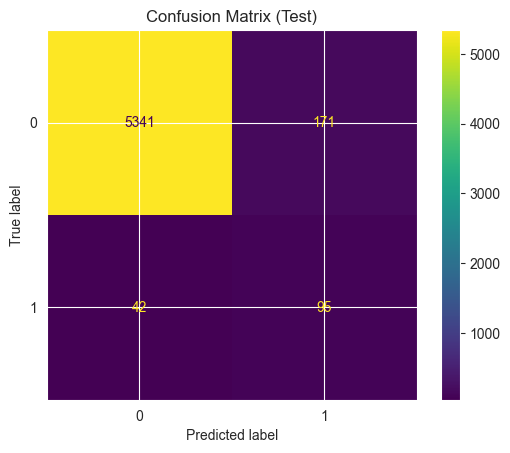

In [15]:
# 1. Preparing data and splitting
df_model = df_origin.copy()
random_state = 69
n_components = 0.01

if 'smurf_flag' in df_model.columns:
    y_all = df_model['smurf_flag']
else:
    y_all = None

# Feature Selection
num_df = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['smurf_flag'], errors='ignore')
base_features = [col for col in num_df.columns if col != 'smurf_score']
X = num_df

# Split
X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]

# Split Labels
if y_all is not None:
    y_train = y_all.loc[X_train_idx]
    y_test = y_all.loc[X_test_idx]
else:
    y_train = y_test = None


def AutoEncoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return autoencoder


scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train[base_features])
X_test_s = scaler.transform(X_test[base_features])

pca = PCA(n_components=n_components)
X_train_p = pca.fit_transform(X_train_s)
X_test_p = pca.transform(X_test_s)

autoencoder = AutoEncoder(X_train_p.shape[1])
autoencoder.fit(X_train_p, X_train_p, epochs=30, batch_size=32, validation_split=0.2, shuffle=True, verbose=0)

train_mse = np.mean(np.square(X_train_p - autoencoder.predict(X_train_p)), axis=1)
test_mse = np.mean(np.square(X_test_p - autoencoder.predict(X_test_p)), axis=1)
threshold = np.percentile(train_mse, 90)  # Kann je nach Ziel auch aggressiver gewählt werden
y_train_auto = (train_mse > threshold).astype(int)
y_test_auto = (test_mse > threshold).astype(int)

models = {
    'IsolationForest': IsolationForest(contamination=0.05, random_state=random_state, n_estimators=100),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=10, contamination=0.05, novelty=True)
}

results = {
    "AutoEncoder_Train": y_train_auto,
    "AutoEncoder_Test": y_test_auto
}

for name, model in models.items():
    # Pipeline with Scaling and PCA
    preproc = ColumnTransformer([
        ('pipeline', make_pipeline(StandardScaler(), PCA(n_components=n_components)), base_features)
    ], remainder='passthrough')

    pipe = make_pipeline(preproc, model)
    pipe.fit(X_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Mapping: -1=Anomaly → 1; 1=Normal → 0
    y_train_bin = (y_train_pred == -1).astype(int)
    y_test_bin = (y_test_pred == -1).astype(int)

    results[f"{name}_Train"] = y_train_bin
    results[f"{name}_Test"] = y_test_bin

vote_train = (sum([results[k] for k in results if k.endswith("_Train")]) >= 2).astype(int)
vote_test = (sum([results[k] for k in results if k.endswith("_Test")]) >= 2).astype(int)

train_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Train"] for model in
                         ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_train.index)
train_df['MajorityVote'] = vote_train
train_df['Dataset'] = 'Train'

test_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Test"] for model in
                        ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_test.index)
test_df['MajorityVote'] = vote_test
test_df['Dataset'] = 'Test'

comparison_df = pd.concat([train_df, test_df])
if y_train is not None and y_test is not None:
    comparison_df['TrueLabel'] = pd.concat([y_train, y_test])

# Labels
if y_train is not None:
    print("\nMajority Vote (Diagnose mit Labels):")
    print("Train:")
    print(classification_report(y_train, vote_train, digits=4))
    print("Test:")
    print(classification_report(y_test, vote_test, digits=4))
    print("\nConfusion Matrix Train:")
    print(confusion_matrix(y_train, vote_train))
    print("\nConfusion Matrix Test:")
    print(confusion_matrix(y_test, vote_test))
    try:
        print("\nROC-AUC Test:", roc_auc_score(y_test, vote_test))
        print("Average Precision (AP) Test:", average_precision_score(y_test, vote_test))
    except Exception as e:
        print("AUC/AP nicht berechenbar:", e)
    ConfusionMatrixDisplay.from_predictions(y_test, vote_test)
    plt.title("Confusion Matrix (Test)")
    plt.show()

C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


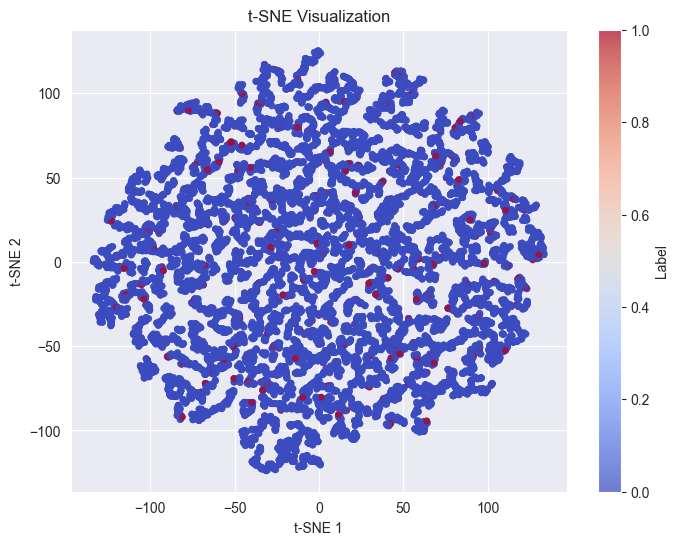

In [5]:
n_components = 0.10

pca = PCA(n_components=n_components)
X_tr = pca.fit_transform(X_train_s)
X_te = pca.transform(X_test_s)

X_tsne = np.vstack((X_tr, X_te))

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_tsne)  # X: shape (n_samples, n_features)

plt.figure(figsize=(8, 6))
if y_all is not None:
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_all, cmap='coolwarm', alpha=0.7, s=16)
    plt.colorbar(label='Label')
else:
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.7, s=16)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [6]:
comparison_df.groupby("Dataset")["MajorityVote"].value_counts()

Dataset  MajorityVote
Test     0                5401
         1                 248
Train    0               21687
         1                 908
Name: count, dtype: int64

In [7]:
df_origin['MajorityVote'] = comparison_df['MajorityVote']
df_origin['MajorityVote']

0        0
1        0
2        0
3        0
4        0
        ..
28239    0
28240    0
28241    0
28242    0
28243    1
Name: MajorityVote, Length: 28244, dtype: int64

In [8]:
outlier = df_origin[df_origin['MajorityVote'] == 1]
good_outlier = outlier[outlier['smurf_score'] == 2]
bad_outlier = outlier[outlier['smurf_score'] == 0]

print("Good Outlier (Smurfs):", good_outlier.shape[0])
print("Bad Outlier:", bad_outlier.shape[0])

y_pred = ((df_origin['MajorityVote'] == 1) & (df_origin['smurf_score'] == 2)).astype(int)
y_true = df_origin['smurf_flag'].astype(int)

print(classification_report(y_true, y_pred, digits=3))

Gute Outlier (Smurfs): 464
Schlechte Outlier: 464
              precision    recall  f1-score   support

           0      0.991     1.000     0.996     27532
           1      1.000     0.652     0.789       712

    accuracy                          0.991     28244
   macro avg      0.996     0.826     0.892     28244
weighted avg      0.991     0.991     0.990     28244



In [9]:
df_origin.groupby('MajorityVote')['smurf_category'].value_counts()

MajorityVote  smurf_category
0             normal            26604
              likely_smurf        450
              definite_smurf       34
1             normal             1058
              likely_smurf         64
              definite_smurf       34
Name: count, dtype: int64

In [10]:
df_origin['riot_id'] = df_origin['riotIdGameName'].astype(str) + '#' + df_origin['riotIdTagline'].astype(str) + ' / ' + \
                       df_origin['gameId'].astype(str)

['Diffdoff2#EUW / 7437397109', 'SeñorMónkey#BAGF / 7438789950',
       'Dellel#EUW / 7437576834', 'meeksooon#win / 7430652424',
       'banana#coco / 7364655002', 'toiletchair951#EUW2 / 7352340198',
       'Engelsblut#KICK / 7432679847', 'Hyacine#E6S5 / 7432679847',
       'Sabstitch Slave#D3DOZ / 7426336630',
       'ItsCalledSoccer#USA1 / 7437654394', 'AfroGamer#EUW / 7429255573',
       'MRW#2222 / 7434332831', 'bmgShade#EUW / 7413699383',
       'Rouladen Rolf#EUW / 7416703754', 'Drmleth#EUW / 7435446611',
       'schizoephrenia#ktmn / 7438250342', 'javift5#EUW / 7435636691',
       'Maskrosen#SID / 7433289996', 'IsaBeck#EUW / 7437505266',
       'Skipiox05#EUW / 7438215512', 'TheHumanSpider#1337 / 7434429026',
       'TitoFuentes#EUW / 7438430547', 'modzarela#EUW / 7434653251',
       'Jonas Bronzraff#EUW / 7402292271', 'MissKXopo#9696 / 7318189100',
       'Unforgiven Blade#YASUO / 7438557339',
       'Erlolo1979#EEB / 7438557339', 'Sytzha#8077 / 7428295159',
       'Triggi#OMEN / 7436458146', 'Mente Fría#T44 / 7433136017',
       'IronmanX36Rebel#EUW / 7314216878', 'sorry#QYB0 / 7352598438',
       'TheHalfShadow#EUW / 7352598438', 'KaynAtm#EUW / 7437527699']

In [12]:
test2 = df_origin[df_origin['smurf_flag'] == 1]
test2['riot_id']

129              Shiyelden#1801 / 7480963751
176                Crawler#THIB / 7308996075
221             Tiaktonris#5733 / 7386669199
265      zoe pink panties#hello / 7273873548
325             Erisghtrod#8092 / 7481851664
                        ...                 
28191                   893#1st / 7466802394
28198                Perrin#YEP / 7466802394
28206               Sky Bri#BBY / 7469952347
28220               agpvzzu#EUW / 7455415368
28243          CrossBonez#GAROU / 7477856837
Name: riot_id, Length: 712, dtype: object

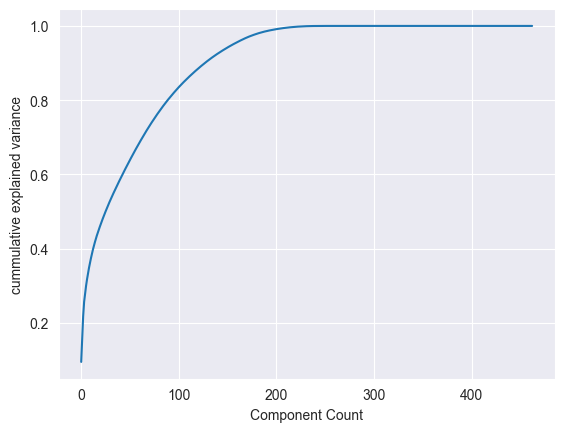

In [14]:
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
pca = PCA().fit(Xs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Count')
plt.ylabel('cummulative explained variance')
plt.show()